# Causal Inference with Multilevel Models: The Electric Company Example

Estimating causal effects from clustered or grouped data requires careful attention to the hierarchical structure of observations. When units are nested within groups—such as students within classrooms, or patients within hospitals—ignoring this structure can lead to incorrect standard errors, inefficient estimates, and invalid causal inferences. Multilevel models provide a principled framework for handling such data while leveraging the advantages of partial pooling across groups.

This notebook reproduces and extends the analysis from **Chapter 23** of Gelman and Hill's *"Data Analysis Using Regression and Multilevel/Hierarchical Models"*. We demonstrate two complementary approaches to modeling treatment effects in hierarchical data: first, a model with varying intercepts that efficiently controls for group-level confounding, and second, a more flexible covariance model that allows treatment effects themselves to vary across groups. Together, these models illustrate how multilevel structures enhance both the efficiency and interpretability of causal effect estimation. In addition to reproducing the analysis, we show how to efficiently vectorize the model (across `grades` and `pairs`) using PyMC.

**Remark:** This example is also treated in [ChiRho](https://basisresearch.github.io/chirho/index.html)'s example notebook [structured latent confounders](https://basisresearch.github.io/chirho/slc.html).

## Context

In the 1970s, an educational television show called **"The Electric Company"** was produced to help children learn to read. A randomized experiment was conducted to estimate the causal effect of watching the show on reading test scores. This study provides an excellent setting for demonstrating multilevel modeling techniques in causal inference, as the experimental design naturally produces clustered data.

## Study Design

The experiment employed a **paired randomized design** across schools and grades:
-   **Pairs**: Classrooms were matched into pairs within the same school and grade (e.g., two 1st grade classes in the same school).
-   **Treatment**: Within each pair, one classroom was randomly assigned to the **treatment group** (watched the show regularly) and the other to the **control group** (did not watch).
-   **Outcome**: Reading test scores at the end of the academic year (`post_test`), with adjustment for pre-test scores (`pre_test`) to increase precision.

This **paired randomized design** is powerful because randomization within pairs ensures that treatment assignment is independent of pair-level confounders such as school quality, neighborhood characteristics, and baseline achievement levels. However, even though treatment assignment is randomized, the data structure is inherently **clustered**: students within the same pair (same school and grade) share common characteristics and are therefore correlated in their outcomes. This clustering means that observations within a pair are not statistically independent—they tend to be more similar to each other than to observations from other pairs. Multilevel models are essential here: they correctly account for this within-pair correlation in the outcome variable, leading to valid standard errors and efficient estimates of both average treatment effects and the heterogeneity of effects across pairs.
## Outline

We proceed in two parts:
-   **Part 1**: We estimate a **Hierarchical Intercept Model** where pair-specific intercepts account for baseline differences across groups while assuming a common treatment effect.
-   **Part 2**: We extend to a **Covariance Model** that allows both intercepts and treatment effects to vary across pairs, capturing treatment effect heterogeneity and estimating the correlation between baseline performance and treatment response.

---
## Part 1: Hierarchical Intercept Model

### Prepare Notebook

We begin by importing the necessary libraries.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from marginaleffects import datagrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed: int = sum(map(ord, "bayes"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

### Read Data

We load the Electric Company dataset (from [Aki Vehtari](https://users.aalto.fi/~ave/)'s repository). The data contains pre-test and post-test reading scores for students in paired classrooms across four grade levels. Each pair consists of one treatment and one control classroom.

In [4]:
data_path = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"
raw_df = pl.read_csv(data_path).drop(["supp", ""]).sort(["grade", "pair_id"])

raw_df.head()

post_test,pre_test,grade,treatment,pair_id
f64,f64,i64,i64,i64
48.9,13.8,1,1,1
52.3,12.3,1,0,1
70.5,16.5,1,1,2
55.0,14.4,1,0,2
89.7,18.5,1,1,3


The dataset includes: `grade` (grade level), `pair_id` (identifier for matched classroom pairs), `treatment` (binary indicator), `pre_test` (baseline reading score), and `post_test` (outcome reading score).

### Exploratory Data Analysis

Before modeling, it is essential to understand the structure and variability in the data. Since the design relies on paired classrooms, we should inspect the distribution of test scores across grades and pairs to identify the sources of variation that our multilevel model must capture.

/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight


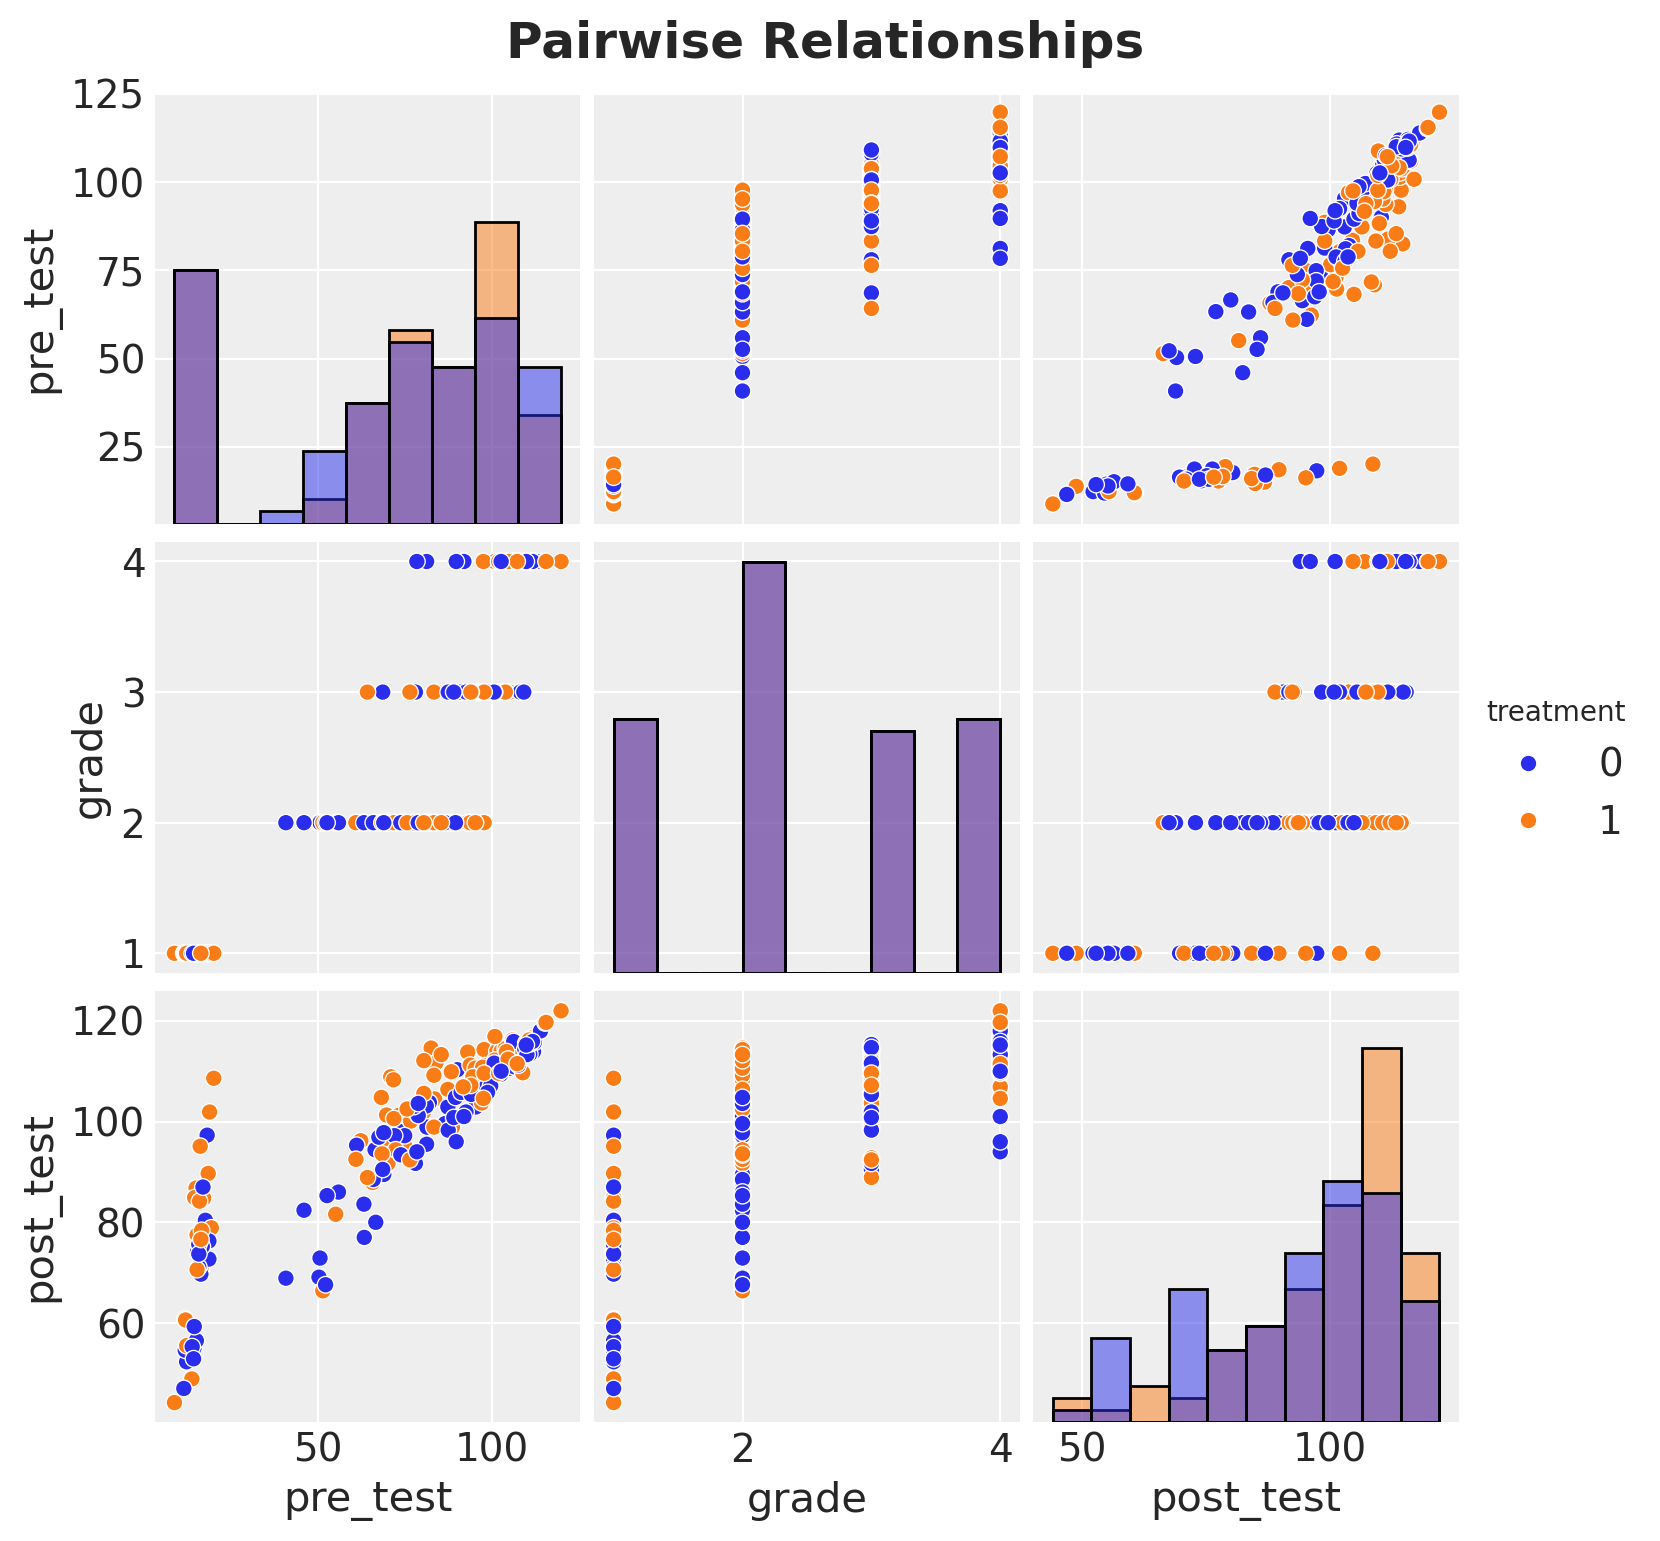

In [5]:
g = sns.pairplot(
    raw_df.to_pandas(),
    vars=["pre_test", "grade", "post_test"],
    hue="treatment",
    diag_kind="hist",
)
g.figure.suptitle("Pairwise Relationships", fontsize=18, fontweight="bold", y=1.02);

The naive treatment effect is the difference between the mean post-test scores of the treatment and control groups:

In [6]:
(
    raw_df.group_by(["grade", "treatment"])
    .agg(pl.col("post_test").mean())
    .pivot(index="grade", on="treatment", values="post_test")
    .with_columns(pl.col("1").sub(pl.col("0")).alias("treatment_effect"))
    .sort(by="grade")
)

grade,0,1,treatment_effect
i64,f64,f64,f64
1,68.790476,77.090476,8.3
2,93.211765,101.570588,8.358824
3,106.175,106.51,0.335
4,110.357143,114.066667,3.709524


### Data Preprocessing

We standardize the numeric variables (test scores) to facilitate prior specification and improve sampling efficiency. Grade and pair identifiers are encoded as integers for use as group indices in the hierarchical model.

In [7]:
numeric_features = ["pre_test", "post_test"]
ordinal_features = ["grade", "pair_id"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("ord", OrdinalEncoder(dtype=int), ordinal_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="polars")


df = preprocessor.fit_transform(raw_df)

df.head()

pre_test,post_test,grade,pair_id,treatment
f64,f64,i64,i64,i64
-1.726248,-2.724052,0,0,1
-1.770568,-2.532096,0,0,0
-1.646472,-1.504567,0,1,1
-1.70852,-2.37966,0,1,0
-1.587379,-0.42058,0,2,1


We extract the covariate matrix containing only the pre-test scores, which will be used to control for baseline differences when estimating the treatment effect.

In [8]:
x_columns = ["pre_test"]
x_df = df[x_columns]

x_df.head()

pre_test
f64
-1.726248
-1.770568
-1.646472
-1.70852
-1.587379


Next, we set up the coordinate system for our PyMC model. This includes dimensions for covariates, grades, pairs, and observations, which will allow us to structure the hierarchical relationships in the data.

In [9]:
n_grades = len(preprocessor["ord"].categories_[ordinal_features.index("grade")])
n_pairs = len(preprocessor["ord"].categories_[ordinal_features.index("pair_id")])

coords = {
    # covariates
    "covariates": x_df.columns,
    # grade
    "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
    # object categories (groups)
    "pair_id": preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    # index
    "obs_idx": np.arange(len(df)),
}

### Model Specification

#### Motivation: Why Multilevel?

The data is **clustered** into pairs of classrooms. Observations within the same pair (same school/grade) are likely correlated due to shared unobserved factors like school quality, neighborhood demographics, or teacher characteristics. Ignoring this structure would violate the independence assumption of standard regression.

To estimate the causal effect, we have two main strategies to handle this clustering:

#### Alternative 1: Fixed Effects (FE)

We could include a **dummy variable (intercept) for every pair**.
-   **Pros**: This controls for **ALL** time-invariant pair-level unobserved confounders. It effectively "closes back doors" related to the school or neighborhood (see *The Effect*, [Chapter 16](https://theeffectbook.net/ch-FixedEffects.html)).
-   **Cons**: It consumes a massive number of degrees of freedom ($N/2$ parameters just for intercepts!). With many small groups (pairs), this can lead to noisy and inefficient estimates. Of course we could use the [Frisch-Waugh-Lovell theorem](https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html#frisch-waugh-lovell) to demean the data as implemented in the [PyFixest](https://github.com/py-econometrics/pyfixest) package.

#### Alternative 2: Random Effects (RE) / Hierarchical Intercepts

We model the pair intercepts as coming from a common distribution, e.g., $\alpha_{j} \sim \text{Normal}(\mu, \sigma)$.
-   **Pros**: This uses **partial pooling**. The model learns the variance $\sigma$ and "shrinks" noisy pair estimates toward the global mean. It is far more efficient than FE.

##### Addressing Random Effects: A Note of Caution

A fundamental concern with Random Effects models, discussed extensively in econometrics and causal inference, is the assumption that group effects are **uncorrelated** with the predictors ($\text{Cov}(\alpha_j, X) = 0$). When this assumption is violated—for example, if high-performing schools both score higher at baseline and implement treatments differently—standard Random Effects estimates can be biased. Fixed Effects models avoid this problem by differencing out all time-invariant group characteristics, making no assumptions about their correlation with predictors. This is why Fixed Effects are often preferred in observational studies where such correlations are likely (Huntington-Klein, 2021, *The Effect*, [Chapter 16](https://theeffectbook.net/ch-FixedEffects.html)).

**Why Random Effects are Valid in this Randomized Design:**

However, the concern about correlation between group effects and predictors does not apply uniformly to all variables. Crucially, in this experiment, **treatment was randomized WITHIN pairs**.
-   Because of randomization, the treatment assignment is **uncorrelated** with the pair's baseline characteristics (the "random effect") by design.
-   The randomization mechanism ensures $\text{Cov}(\alpha_j, T_i) = 0$ for the treatment variable, even if $\text{Cov}(\alpha_j, X_i) \neq 0$ for other covariates.
-   Therefore, the standard critique of Random Effects does not threaten the validity of our causal effect estimate for treatment, though we may still need to control for other confounders like pre-test scores.

We can thus use a **Hierarchical Intercept Model** to efficiently control for pair-level heterogeneity and obtain correct standard errors without the heavy penalty of Fixed Effects.

$$
\begin{align}
\text{post\_test}_i &\sim \text{Normal}(\mu_i, \sigma_y) \\
\mu_i &= \alpha_{\text{pair}[i]} + \beta_T \cdot T_i + \beta_x \cdot \text{pre\_test}_i\\
\alpha_j &\sim \text{Normal}(\mu_\alpha, \sigma_\alpha)
\end{align}
$$

Here, $i$ indexes observations, $j$ indexes pairs, $T_i$ is the treatment indicator, and $\alpha_j$ are the pair-specific intercepts. The hierarchical structure on $\alpha_j$ implements partial pooling: pairs with little data are shrunk toward the grade-level mean $\mu_\alpha$, while pairs with more data are allowed to deviate. We implement this using a non-centered parametrization for improved sampling efficiency.

Regarding the hierarchical structure: we use a non-centered parametrization for the random intercepts to improve sampling efficiency (for details, see [A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html)).

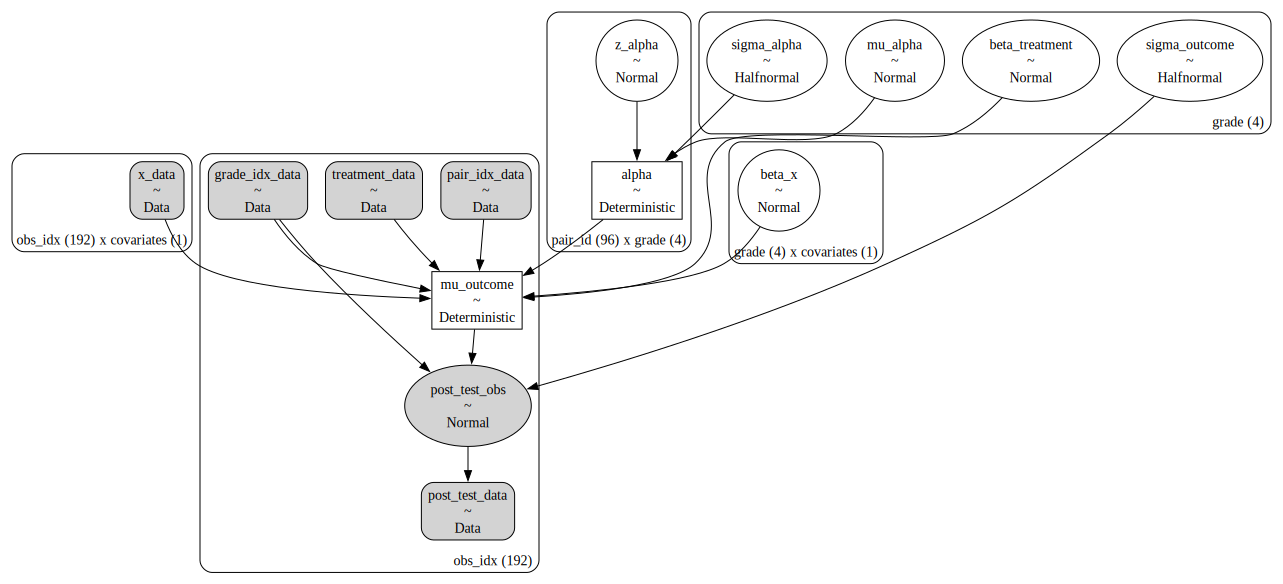

In [10]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1, dims=("grade"))
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1, dims=("grade"))
    # auxiliary variable for the non-centered parametrization
    z_alpha = pm.Normal("z_alpha", mu=0, sigma=1, dims=("pair_id", "grade"))

    beta_treatment = pm.Normal("beta_treatment", mu=0, sigma=1, dims=("grade"))
    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims=("grade", "covariates"))

    sigma_outcome = pm.HalfNormal("sigma_outcome", sigma=1, dims=("grade"))

    # --- Parametrization ---
    # Non-centered parametrization for the random intercepts
    alpha = pm.Deterministic(
        "alpha", mu_alpha + z_alpha * sigma_alpha, dims=("pair_id", "grade")
    )

    mu_outcome = pm.Deterministic(
        "mu_outcome",
        alpha[pair_idx_data, grade_idx_data]
        + beta_treatment[grade_idx_data] * treatment_data
        + (beta_x[grade_idx_data] * x_data).sum(axis=-1),
        dims=("obs_idx"),
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome[grade_idx_data],
        observed=post_test_data,
        dims="obs_idx",
    )


pm.model_to_graphviz(model)

The graphical representation above shows the dependency structure of our model: how the observed data (`post_test_obs`) depends on the hierarchical parameters through the mean structure (`mu_outcome`).

### Prior Predictive Check

Before fitting the model to data, we simulate from the prior distribution to ensure our priors are reasonable and produce plausible outcomes. This step helps detect specification errors and poorly calibrated priors.

In [12]:
with model:
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [beta_treatment, beta_x, mu_alpha, post_test_obs, sigma_alpha, sigma_outcome, z_alpha]


Text(0.5, 1.02, 'Prior Predictive Check')

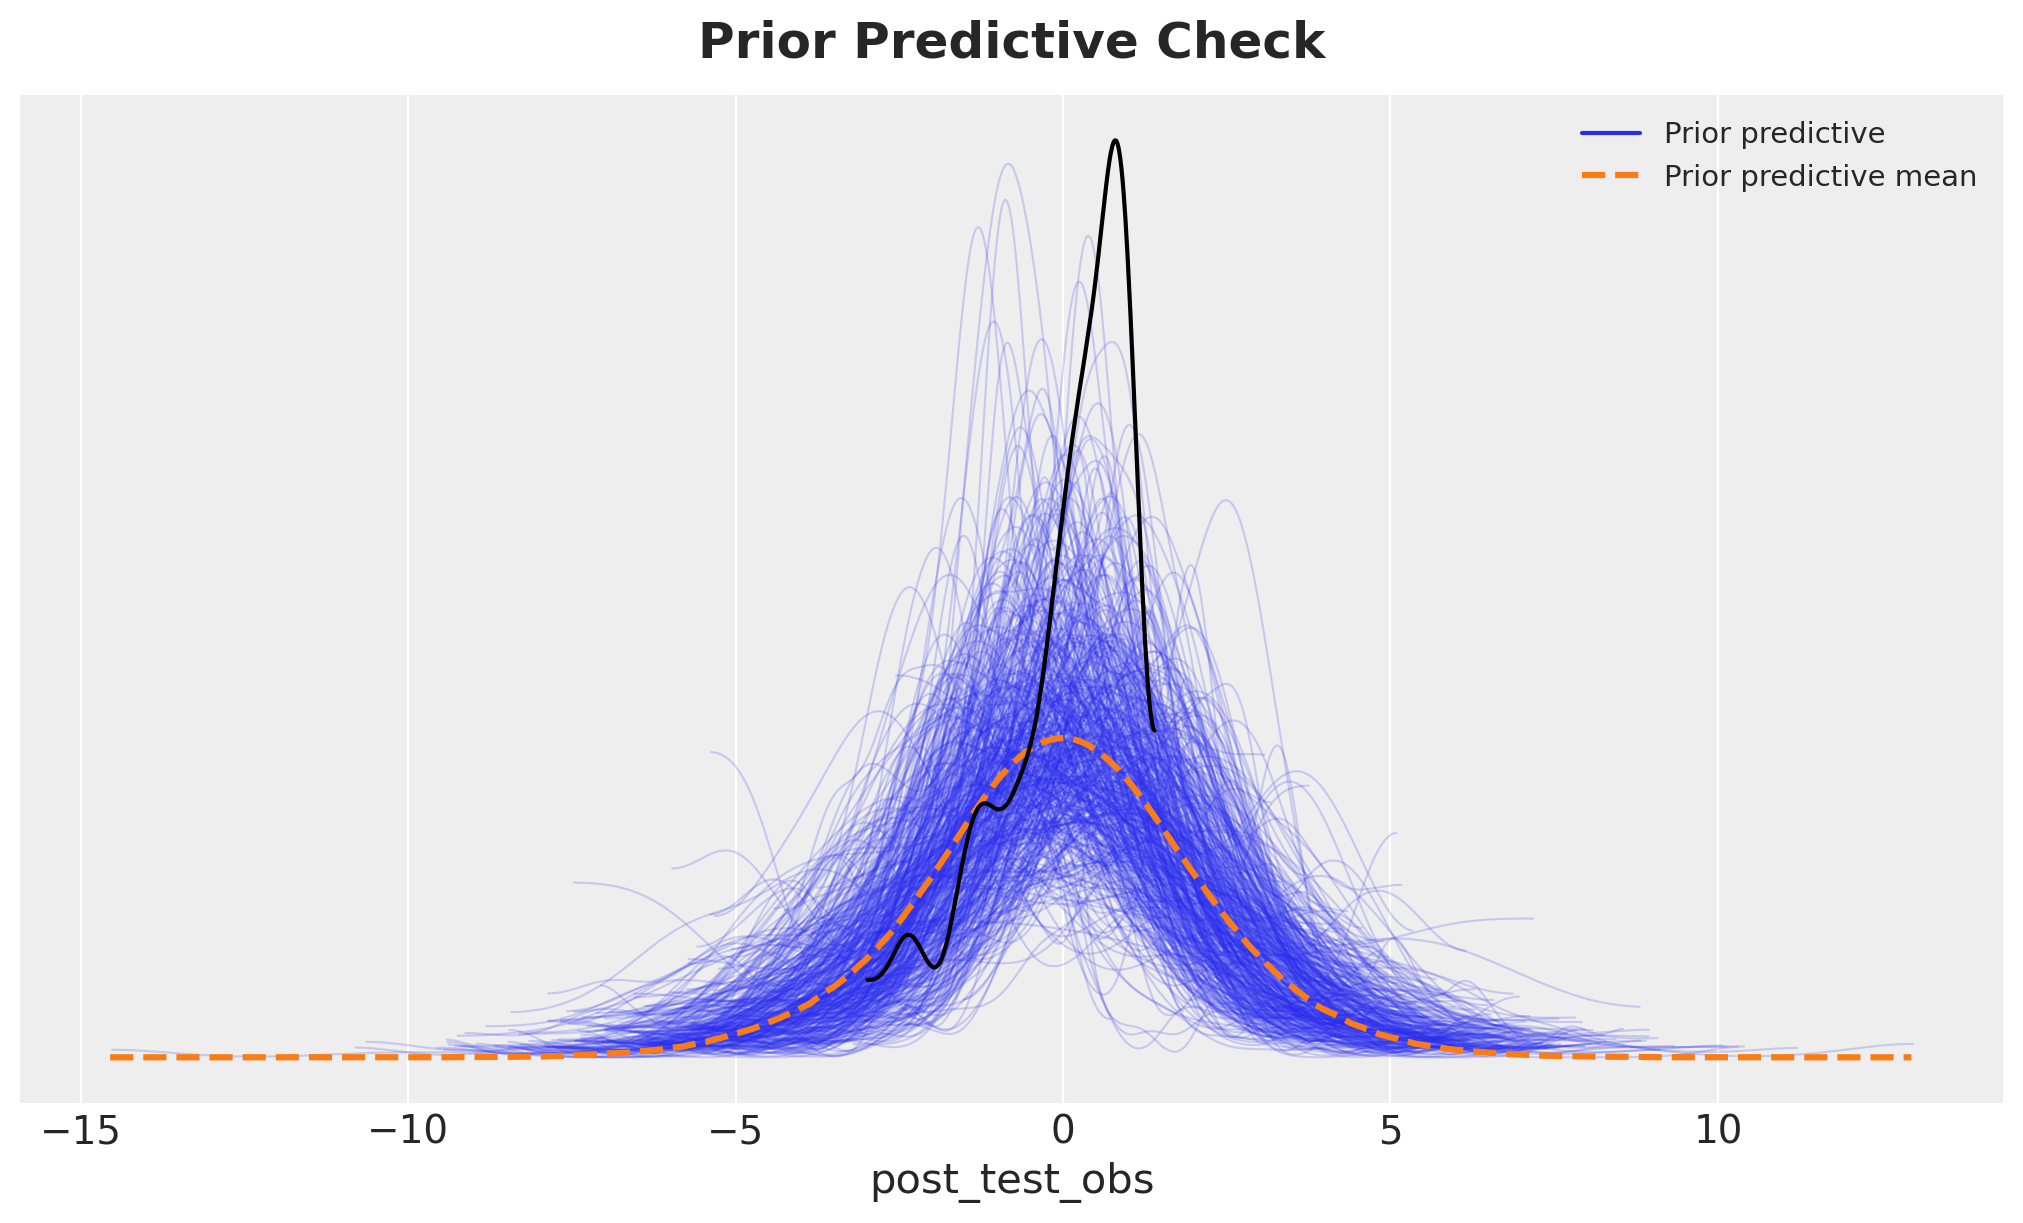

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="prior", ax=ax)
az.plot_dist(df["post_test"].to_numpy(), color="black", ax=ax)
ax.set_title("Prior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

The prior predictive distribution (blue) is compared against the observed data (black). The priors allow for a wide range of plausible outcomes, which is appropriate given our standardized data. The overlap indicates that the observed data are not surprising under our prior assumptions.

### Posterior Inference

We now fit the model using Hamiltonian Monte Carlo (HMC) via the NumPyro backend.

In [14]:
with model:
    idata.extend(
        pm.sample(
            tune=1_500,
            draws=1_000,
            target_accept=0.9,
            chains=4,
            nuts_sampler="numpyro",
        )
    )

    idata.extend(pm.sample_posterior_predictive(idata))

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling: [post_test_obs]


Output()

After sampling, we generate posterior predictive samples to assess model fit. These predictions will be used to evaluate how well the model captures the observed data patterns.

### Model Diagnostics

We check for sampling pathologies that would indicate problems with the posterior geometry or sampler configuration. The primary diagnostic is the number of divergent transitions, which should ideally be zero.

In [15]:
idata["sample_stats"]["diverging"].sum().item()

0

No divergent transitions indicate that the sampler successfully explored the posterior without encountering problematic curvature. We also examine the summary statistics and trace plots to assess convergence.

In [16]:
az.summary(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment[1],0.468,0.136,0.225,0.727,0.002,0.002,5763.0,2709.0,1.00
beta_treatment[2],0.233,0.058,0.129,0.344,0.001,0.001,3669.0,2462.0,1.00
beta_treatment[3],0.106,0.041,0.027,0.184,0.001,0.001,4190.0,2981.0,1.00
beta_treatment[4],0.093,0.036,0.023,0.160,0.001,0.001,4782.0,2739.0,1.00
"beta_x[1, pre_test]",1.520,0.534,0.500,2.497,0.011,0.008,2353.0,2555.0,1.00
"beta_x[2, pre_test]",1.554,0.113,1.345,1.772,0.002,0.002,2349.0,2794.0,1.00
"beta_x[3, pre_test]",1.309,0.081,1.156,1.456,0.002,0.001,2610.0,2772.0,1.00
"beta_x[4, pre_test]",1.274,0.093,1.103,1.449,0.002,0.001,1628.0,1915.0,1.00
mu_alpha[1],0.921,0.884,-0.766,2.510,0.018,0.013,2454.0,2540.0,1.00
mu_alpha[2],-0.152,0.056,-0.253,-0.044,0.001,0.001,1928.0,2395.0,1.00


The summary statistics show effective sample sizes (ESS) and $\hat{R}$ diagnostics for key parameters. Values of $\hat{R} \approx 1$ indicate convergence across chains. The treatment effect parameter (`beta_treatment`) and variance components are our main interest.

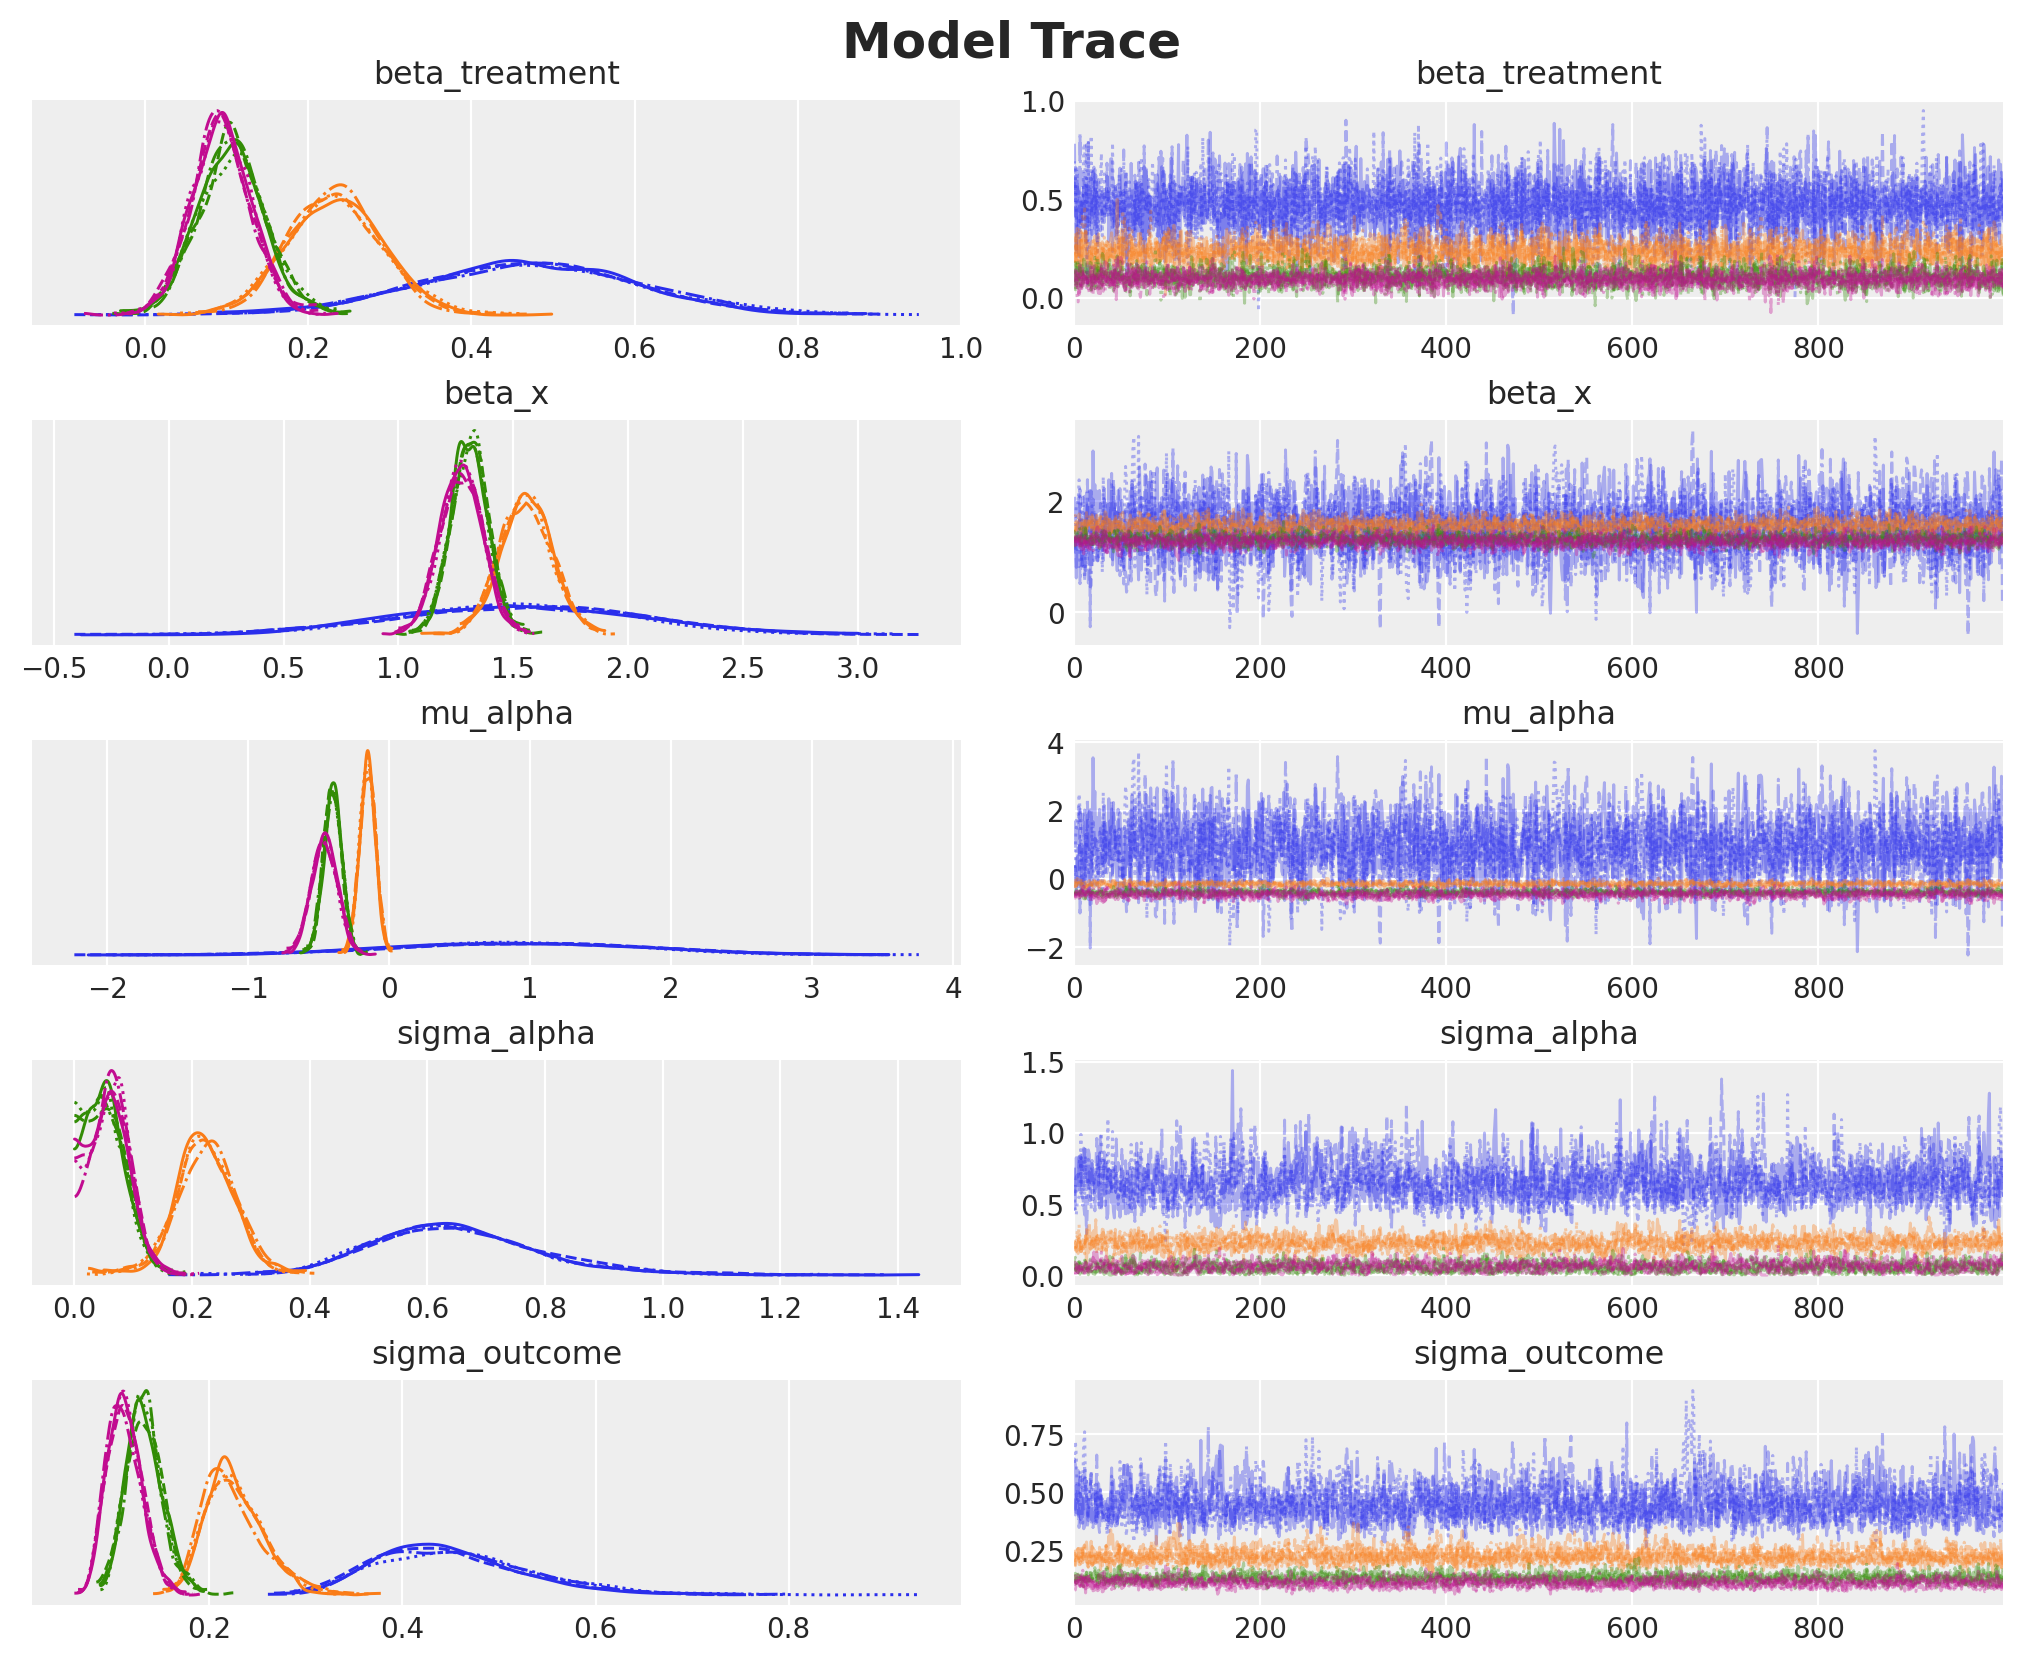

In [18]:
axes = az.plot_trace(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
    figsize=(10, 8),
)


plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold", y=1.02);

The trace plots show good mixing across chains (overlapping colors) and stable posterior distributions (smooth histograms on the left). The chains have converged to stationary distributions, confirming the reliability of our posterior estimates.

Next, we check the posterior predictive distribution.

Text(0.5, 1.02, 'Posterior Predictive Check')

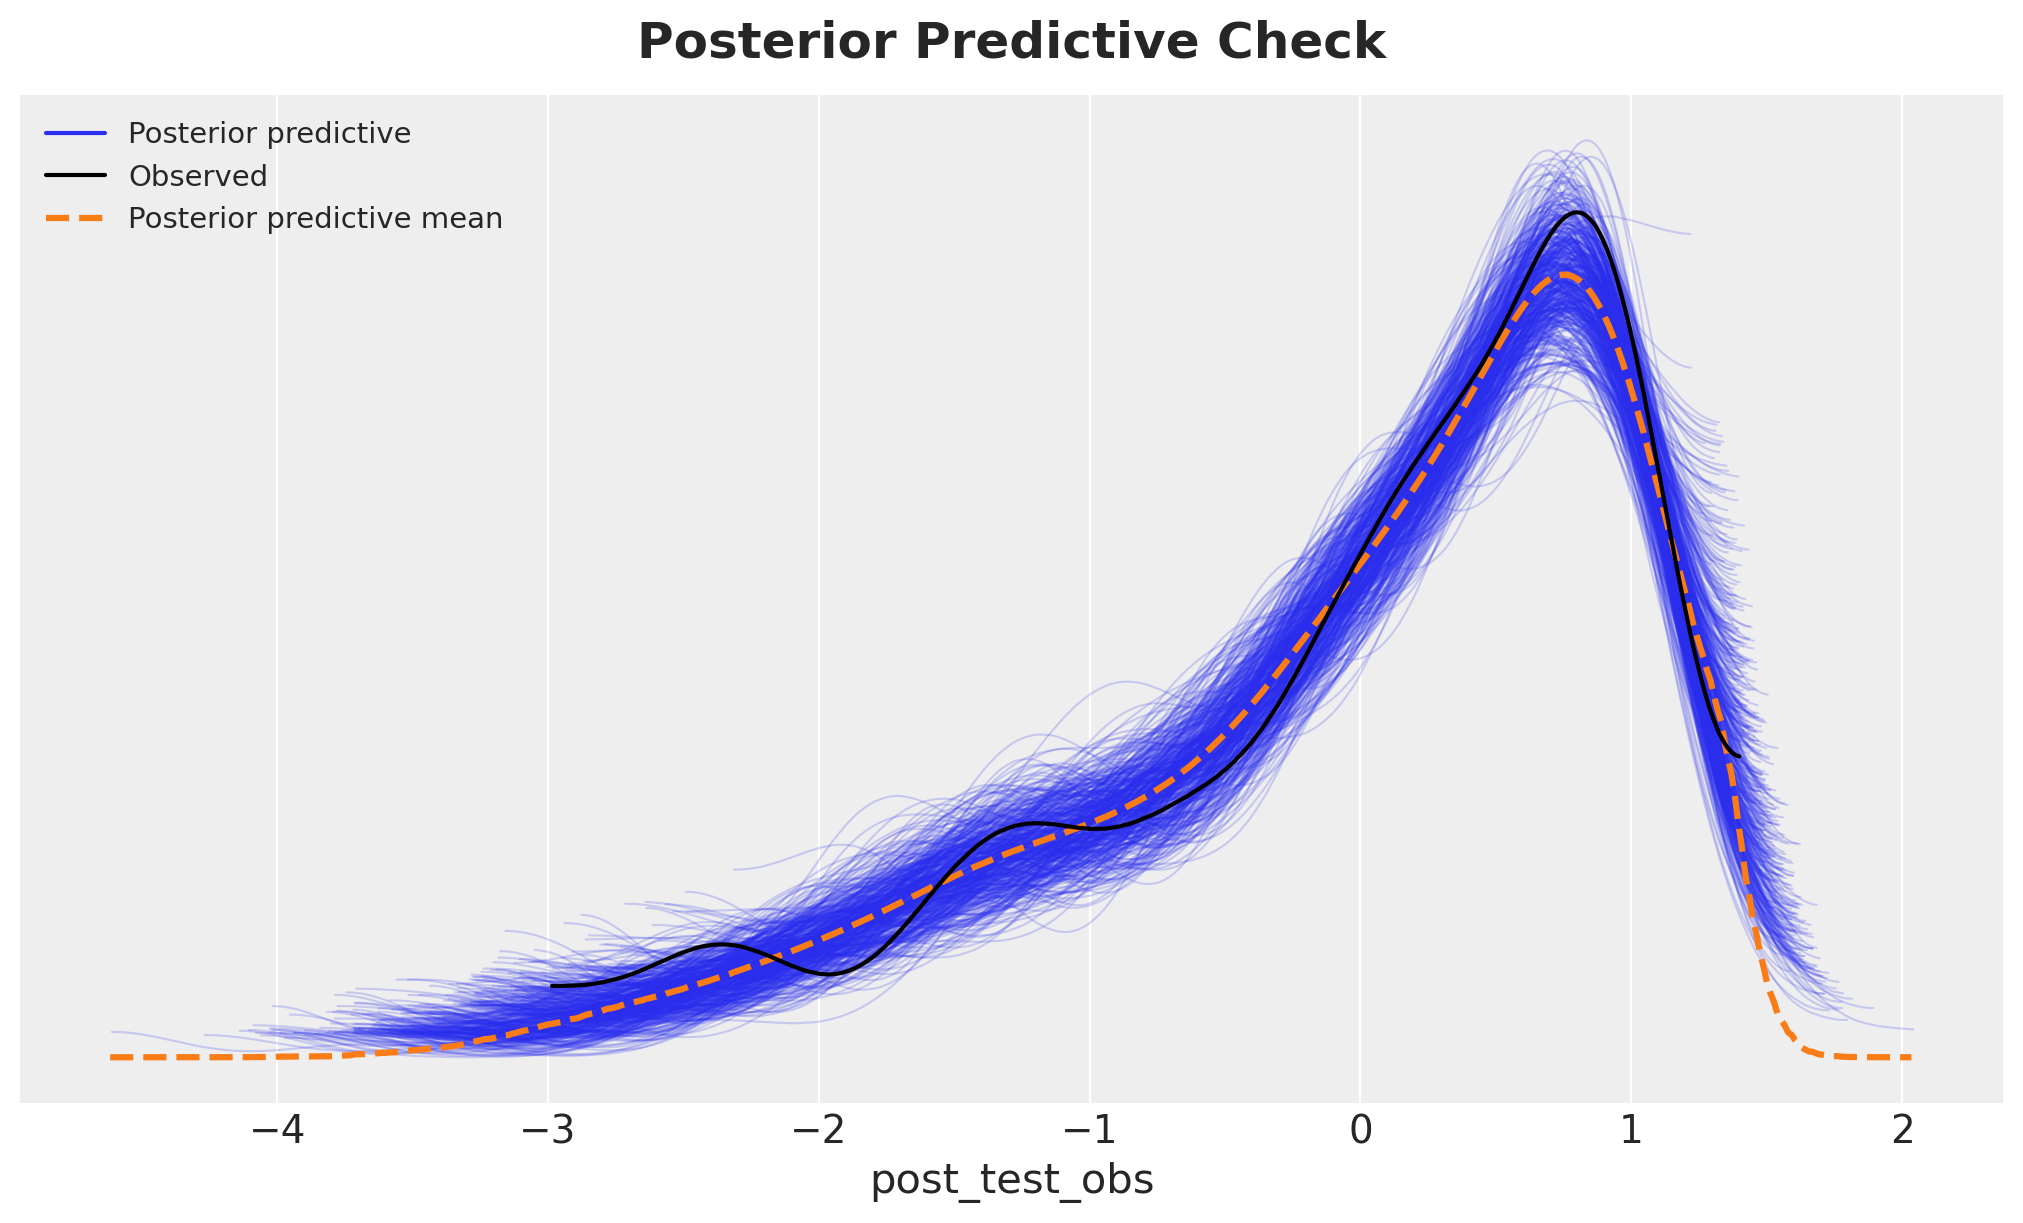

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="posterior", num_pp_samples=500, ax=ax)
ax.set_title("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

The posterior predictive distribution closely matches the observed data, indicating that the model captures the essential features of the data-generating process. 

### Treatment Effect Estimates

We now examine the estimated treatment effects. The parameter `beta_treatment` represents the average causal effect of watching "The Electric Company" on standardized test scores, estimated separately for each grade level.

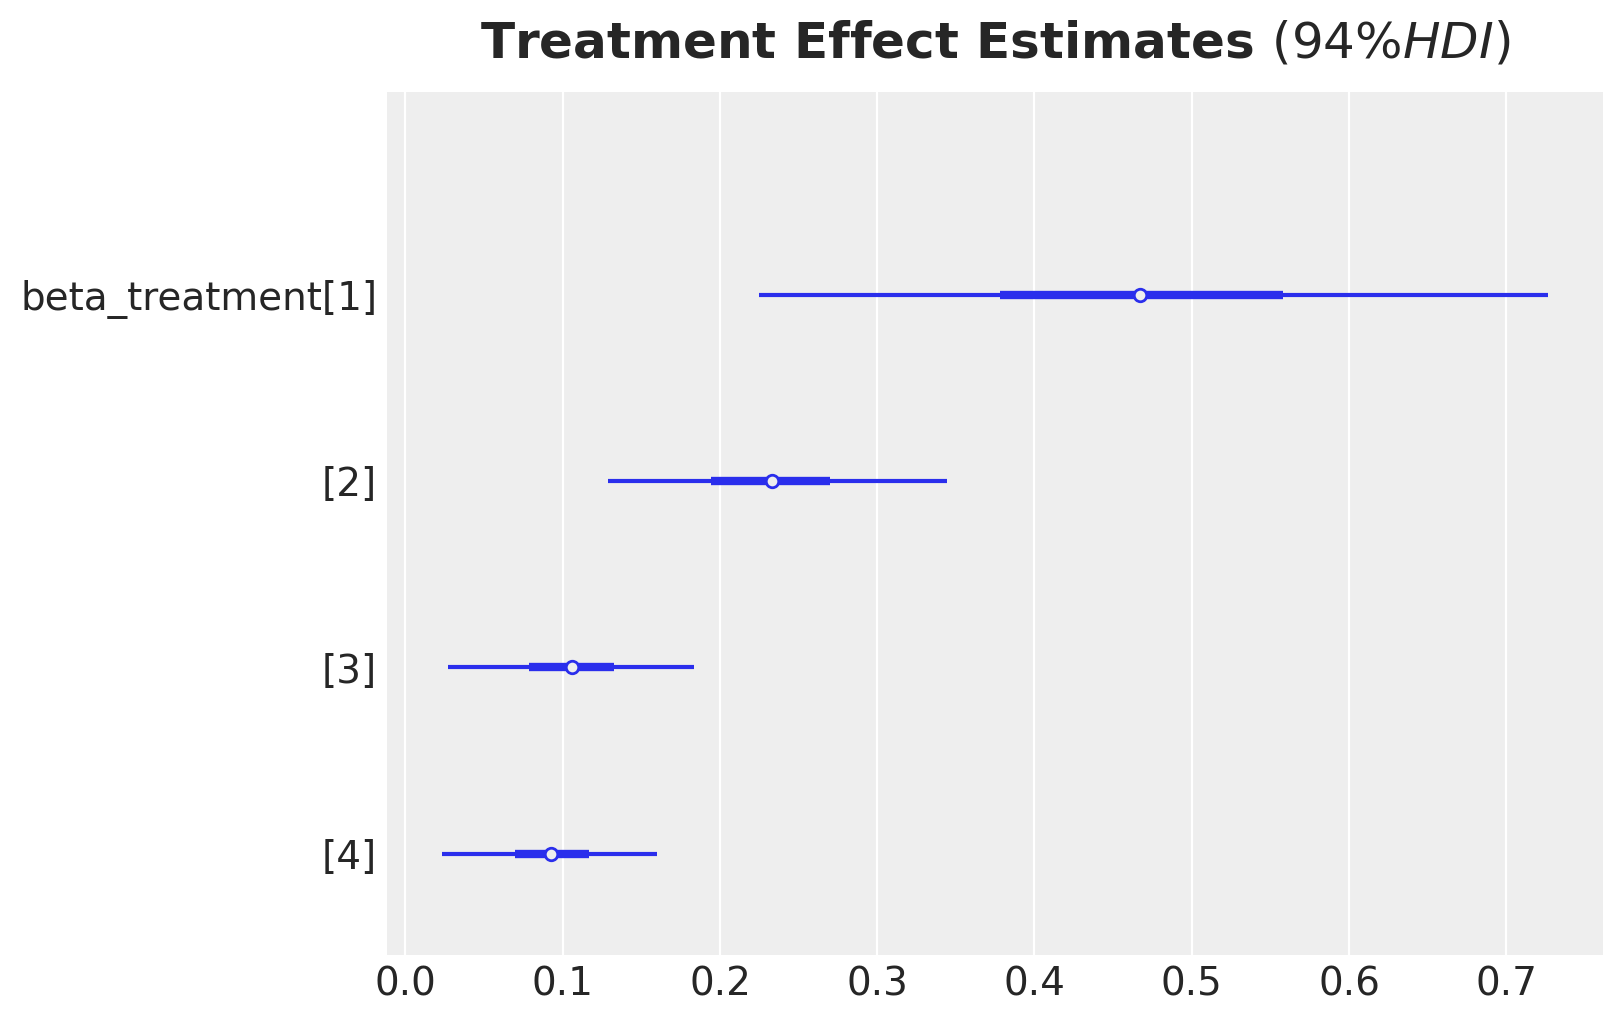

In [ ]:
ax, *_ = az.plot_forest(
    idata,
    combined=True,
    var_names=["beta_treatment"],
    figsize=(8, 5),
)
ax.set_title(
    r"Treatment Effect Estimates $(94\% HDI)$",
    fontsize=18,
    fontweight="bold",
    y=1.02,
);

The forest plot shows the posterior distributions of treatment effects for each grade. The point estimates and credible intervals provide evidence about the magnitude and uncertainty of the causal effect. To interpret these effects in the original scale, we transform them back from standardized units.

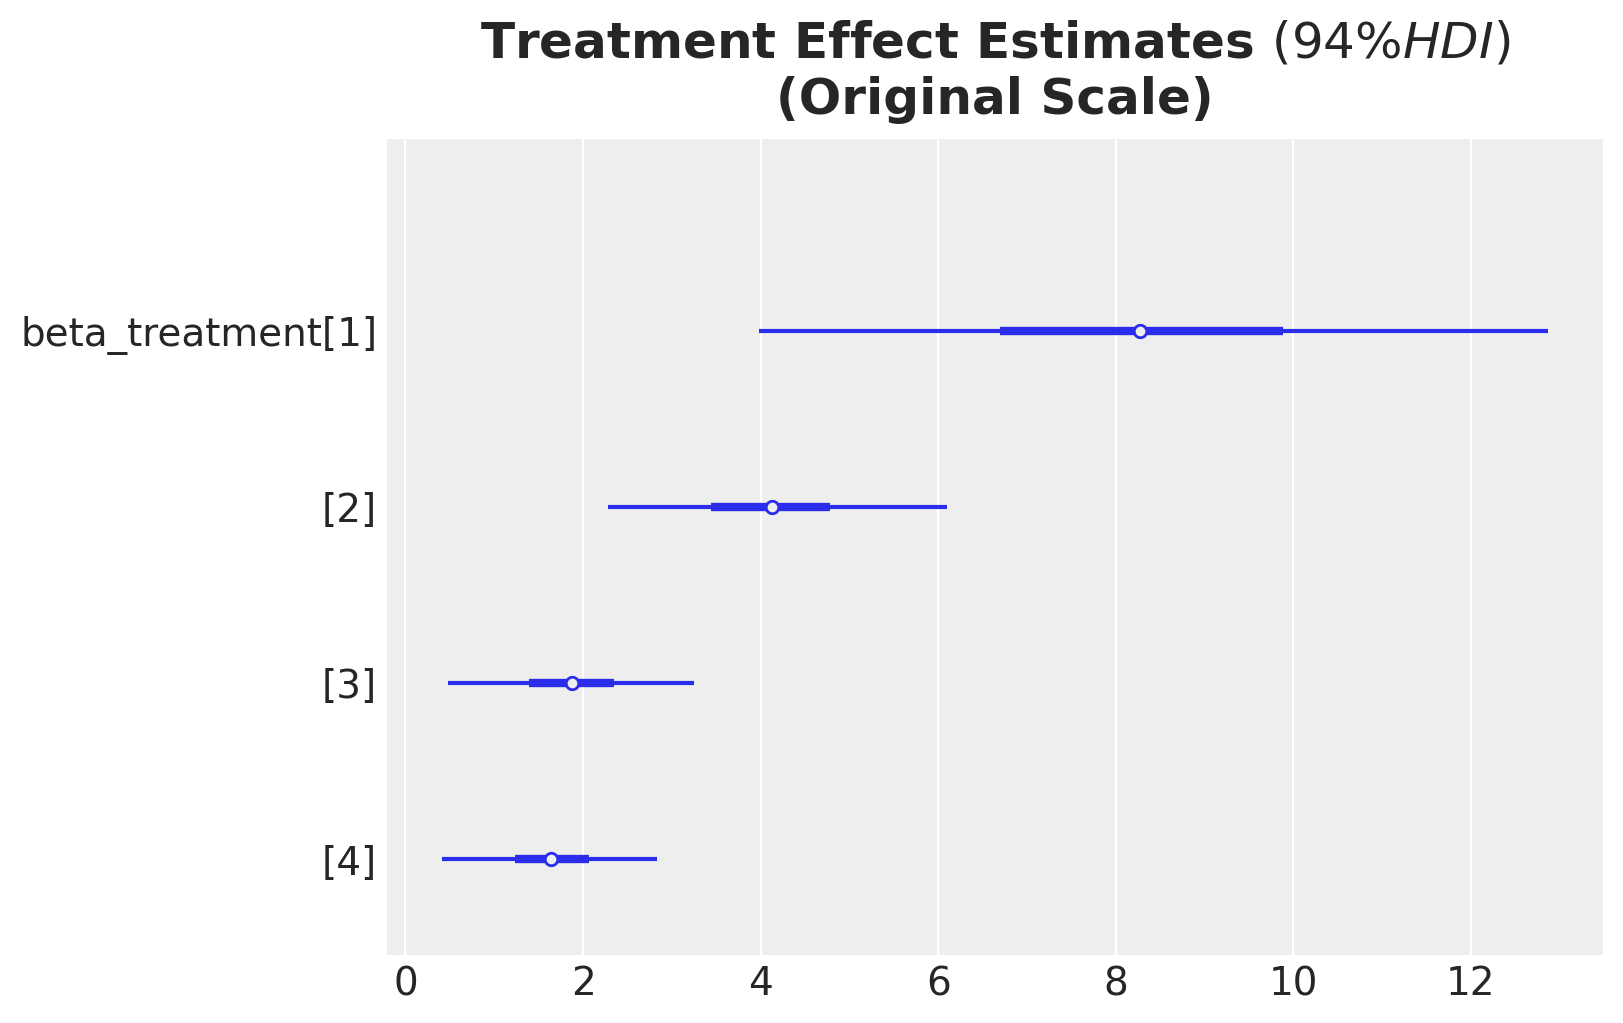

In [39]:
ax, *_ = az.plot_forest(
    idata["posterior"]["beta_treatment"]
    * preprocessor["num"].scale_[numeric_features.index("post_test")],
    combined=True,
    var_names=["beta_treatment"],
    figsize=(8, 5),
)
ax.set_title(
    r"Treatment Effect Estimates $(94\% HDI)$ (Original Scale)",
    fontsize=18,
    fontweight="bold",
    y=1.02,
);

These are the treatment effects expressed in the original units of the test scores. Positive values indicate that the treatment group (who watched the show) scored higher on average than the control group. These values, match the results from the book.

### Counterfactual Prediction Grids

To compute the average treatment effect (ATE) more explicitly, we construct prediction grids that span the range of pre-test scores for both treatment and control conditions. This allows us to compute counterfactual predictions: what would have happened to the same students under both treatment and control.

In [ ]:
raw_df_control_grid = datagrid(
    newdata=raw_df,
    treatment=0,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_control_grid = preprocessor.transform(raw_df_control_grid)
df_control_grid.columns = [col.split("__")[-1] for col in df_control_grid.columns]
x_df_control_grid = df_control_grid[x_columns]

raw_df_treatment_grid = datagrid(
    newdata=raw_df,
    treatment=1,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_treatment_grid = preprocessor.transform(raw_df_treatment_grid)
df_treatment_grid.columns = [col.split("__")[-1] for col in df_treatment_grid.columns]
x_df_treatment_grid = df_treatment_grid[x_columns]

We have created two grids: one with treatment set to 0 (control) and one with treatment set to 1 (treated), both spanning the observed range of pre-test scores and all grade-pair combinations.

### Counterfactual Estimates

We now generate posterior predictive samples under each counterfactual scenario. For the control grid, we predict outcomes as if all students were in the control condition. For the treatment grid, we predict outcomes as if all students watched the show.

In [ ]:
with model:
    pm.set_data(
        new_data={
            "x_data": x_df_control_grid,
            "grade_idx_data": df_control_grid["grade"].to_numpy(),
            "pair_idx_data": df_control_grid["pair_id"].to_numpy(),
            "treatment_data": df_control_grid["treatment"].to_numpy(),
            "post_test_data": df_control_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_control_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_control_grid)),
        },
    )

    posterior_predictive_control = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

The control counterfactual predictions represent the expected outcomes in the absence of treatment, conditioning on the observed covariates and the estimated model parameters.

In [ ]:
with model:
    pm.set_data(
        new_data={
            "x_data": x_df_treatment_grid,
            "grade_idx_data": df_treatment_grid["grade"].to_numpy(),
            "pair_idx_data": df_treatment_grid["pair_id"].to_numpy(),
            "treatment_data": df_treatment_grid["treatment"].to_numpy(),
            "post_test_data": df_treatment_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_treatment_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_treatment_grid)),
        },
    )

    posterior_predictive_treatment = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Similarly, the treatment counterfactual predictions represent expected outcomes if all students had watched the show. The difference between these two counterfactuals yields the causal effect.

### Results: Treatment Effect Estimates

We can now compute the **average treatment effect (ATE)** by comparing the posterior predictive distributions under the counterfactual scenarios (Treatment vs. Control). The difference between these predictions, averaged across all observations in the grid, provides a distribution for the causal effect.

For illustration, we focus on Grade 1 students. We first extract and transform the predictions back to the original scale of test scores.

In [ ]:
control_mask = (
    raw_df_control_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
control_posterior_grade = posterior_predictive_control["posterior_predictive"][
    "mu_outcome"
][:, :, control_mask]

original_scale_control_posterior_grade = (
    control_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

treatment_mask = (
    raw_df_treatment_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
treatment_posterior_grade = posterior_predictive_treatment["posterior_predictive"][
    "mu_outcome"
][:, :, treatment_mask]

original_scale_treatment_posterior_grade = (
    treatment_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

We now visualize the posterior distribution of the average treatment effect for Grade 1. The first plot shows the effect computed from the counterfactual predictions, while the second shows the direct coefficient estimate. These should be consistent, providing a validation of our approach.

In [ ]:
az.plot_posterior(
    (
        original_scale_treatment_posterior_grade
        - original_scale_control_posterior_grade
    ).mean(dim=("obs_idx"))
)
az.plot_posterior(
    (
        idata["posterior"]["beta_treatment"]
        * preprocessor["num"].scale_[numeric_features.index("post_test")]
    ).sel(grade=1)
)

Both approaches yield similar posterior distributions, confirming the robustness of our causal effect estimate. The positive treatment effect indicates that watching "The Electric Company" improved reading scores for Grade 1 students. The credible intervals quantify our uncertainty about the magnitude of this effect.

---
## Part 2: Covariance Model

### Motivation: Modeling Treatment Effect Heterogeneity

The hierarchical intercept model in Part 1 assumes that the treatment effect is constant across all pairs (after accounting for grade differences). While this model efficiently controls for pair-level confounding, it does not allow us to explore whether the treatment effect varies across pairs. In practice, some schools or classrooms may respond more strongly to the intervention than others due to unmeasured factors such as teacher implementation fidelity, student engagement, or local context.

To capture this **treatment effect heterogeneity**, we extend our model to allow both the baseline intercept $\alpha_j$ and the treatment effect $\theta_j$ to vary across pairs. Moreover, we model the joint distribution of these pair-specific parameters using a bivariate normal distribution with a covariance structure:

$$
\begin{pmatrix} \alpha_j \\ \theta_j \end{pmatrix} \sim N\left(\begin{pmatrix} \mu_\alpha \\ \mu_\theta \end{pmatrix}, \Sigma\right)
$$

where $\Sigma$ is a $2 \times 2$ covariance matrix. The off-diagonal elements of $\Sigma$ capture the correlation between baseline performance and treatment response. For example, a positive correlation would indicate that pairs with higher baseline scores also tend to experience larger treatment effects, while a negative correlation would suggest compensatory effects (treatment helps struggling pairs more).

#### Benefits of Modeling Covariances

This approach represents what Huntington-Klein (2021, *The Effect*, Chapter 16) calls "Advanced Random Effects" or multi-level modeling. By explicitly modeling the covariance structure, we gain several advantages over both standard Fixed Effects and basic Random Effects:

-   **Captures heterogeneity**: We estimate not just the average treatment effect $\mu_\theta$, but also the distribution of pair-specific effects $\theta_j$, revealing how treatment impacts vary across contexts.
-   **Partial pooling on treatment effects**: Noisy pair-specific estimates are shrunk toward the population mean, borrowing strength across groups. This provides more stable estimates than treating each pair entirely separately.
-   **Correlation structure**: We learn whether baseline performance and treatment response are related, which can inform targeting and generalization of the intervention. This addresses the limitation of basic Random Effects by explicitly modeling the relationship between group characteristics and effects.
-   **Separation of between and within effects**: By allowing both intercepts and slopes to vary, we can distinguish population-level patterns from group-specific deviations, providing richer substantive interpretation.
-   **Efficiency with hierarchical data**: Multi-level models make full use of the hierarchical structure, improving statistical efficiency compared to Fixed Effects while relaxing the strong independence assumptions of basic Random Effects.

We implement this model using a non-centered parametrization with a Cholesky decomposition of the covariance matrix for computational efficiency. The following helper functions construct correlation and covariance matrices in a vectorized manner for each grade level.

In [ ]:
def vectorized_correlation_matrices(corr_values, size=2):
    n_matrices = corr_values.shape[0]

    # Reshape for broadcasting
    # Use reshape or expand_dims instead of dimshuffle
    corr_expanded = pt.reshape(corr_values, (n_matrices, 1, 1))

    # Create base: all elements are correlation values
    base = corr_expanded * pt.ones((n_matrices, size, size))

    # Create diagonal mask
    diag_mask = pt.eye(size, dtype="bool")

    # Set diagonal to 1
    return pt.where(diag_mask, 1.0, base)


def vectorized_diagonal_matrices_v4(values):
    k = values.shape[1]  # 2

    # Create identity matrix (2, 2)
    identity_matrix = pt.eye(k)

    # Reshape values for broadcasting: (4, 2) -> (4, 2, 1)
    values_expanded = values[:, :, None]

    # Multiply: (4, 2, 1) * (2, 2) -> (4, 2, 2)
    # This puts values[i, j] at position [i, j, j]
    return values_expanded * identity_matrix

### Prior Specification for Correlation

Before specifying the full model, we visualize our prior distribution for the correlation parameter. We use a Beta(20, 4) distribution (scaled to [-1, 1]) to encode a prior belief that the correlation between intercepts and treatment effects is likely positive but with substantial uncertainty. This prior is weakly informative and allows the data to dominate the posterior inference.

In [ ]:
pz.Beta(alpha=20, beta=4).plot_pdf(pointinterval=True)

The Beta distribution shown above is transformed to the correlation scale via the mapping $\rho = 2 \times \text{Beta}(20, 4) - 1$. This induces a prior that favors positive correlations but remains flexible enough to accommodate a range of values.

### Model Specification

We now specify the full covariance model. The key difference from Part 1 is that both the intercept and the treatment effect vary by pair. The model structure is:

$$
\begin{align}
\text{post\_test}_i &\sim N(\mu_i, \sigma_y) \\
\mu_i &= \alpha_{\text{pair}[i]} + \theta_{\text{pair}[i]} \cdot T_i + \beta_x \cdot \text{pre\_test}_i \\
\begin{pmatrix} \alpha_j \\ \theta_j \end{pmatrix} &\sim N\left(\begin{pmatrix} \mu_\alpha \\ \mu_\theta \end{pmatrix}, \Sigma\right)
\end{align}
$$

where $\Sigma$ is decomposed as $\Sigma = D \Omega D$, with $D$ being a diagonal matrix of standard deviations and $\Omega$ being the correlation matrix. This decomposition allows us to place separate priors on the marginal variances and the correlation structure, which improves interpretability and sampling efficiency.

The non-centered parametrization introduces a latent variable $u_{\text{raw}} \sim N(0, I)$ and transforms it via the Cholesky factor of $\Sigma$ to obtain the correlated random effects $(u_0, u_1)$ corresponding to $(\alpha_j - \mu_\alpha, \theta_j - \mu_\theta)$.

In [ ]:
coords.update({"effect": ["intercept", "slope"], "effect_copy": ["intercept", "slope"]})
coords.update({"corr_dim": ["corr_dim_1"]})


with pm.Model(coords=coords) as cov_model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---

    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims=("grade", "covariates"))
    sigma_outcome = pm.HalfNormal("sigma_outcome", sigma=1, dims=("grade"))

    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=0.5, dims=("grade"))
    mu_theta = pm.Normal("mu_theta", mu=0, sigma=0.5, dims=("grade"))

    # Group-level standard deviations
    sigma_u = pm.HalfNormal(
        "sigma_u", sigma=np.array([0.2, 0.2]), dims=("grade", "effect")
    )

    # Triangular upper part of the correlation matrix
    # omega_triu = pm.LKJCorr("omega_triu", eta=1, n=2, dims=("grade", "corr_dim"))
    omega_triu = pm.Beta("omega_triu", alpha=20, beta=4, dims=("grade", "corr_dim"))
    omega_triu_scaled = omega_triu * 2 - 1

    # Construct correlation matrix
    omega = pm.Deterministic(
        "omega",
        vectorized_correlation_matrices(omega_triu_scaled),
        dims=("grade", "effect", "effect_copy"),
    )

    # Construct diagonal matrix of standard deviation
    sigma_diagonal = pm.Deterministic(
        "sigma_diagonal",
        vectorized_diagonal_matrices_v4(sigma_u),
        dims=("grade", "effect", "effect_copy"),
    )

    # Compute covariance matrix
    cov = pm.Deterministic(
        "cov",
        pt.einsum("bij,bjk,bkl->bil", sigma_diagonal, omega, sigma_diagonal),
        dims=("grade", "effect", "effect_copy"),
    )

    # Cholesky decomposition of covariance matrix
    cholesky_cov = pm.Deterministic(
        "cholesky_cov",
        pt.slinalg.cholesky(cov),
        dims=("grade", "effect", "effect_copy"),
    )

    # And finally get group-specific coefficients
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("grade", "effect", "pair_id"))
    u = pm.Deterministic(
        "u",
        pt.einsum("bik,bkj->bji", cholesky_cov, u_raw),
        dims=("grade", "pair_id", "effect"),
    )

    u0 = pm.Deterministic("u0", u[:, :, 0], dims=("grade", "pair_id"))
    u1 = pm.Deterministic("u1", u[:, :, 1], dims=("grade", "pair_id"))

    alpha = pm.Deterministic("alpha", mu_alpha + u0.T, dims=("pair_id", "grade"))
    theta = pm.Deterministic("theta", mu_theta + u1.T, dims=("pair_id", "grade"))

    mu_outcome = pm.Deterministic(
        "mu_outcome",
        alpha[pair_idx_data, grade_idx_data]
        + theta[pair_idx_data, grade_idx_data] * treatment_data
        + (beta_x[grade_idx_data] * x_data).sum(axis=-1),
        dims=("obs_idx"),
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome[grade_idx_data],
        observed=post_test_data,
        dims="obs_idx",
    )

pm.model_to_graphviz(cov_model)

The graphical model representation shows the more complex dependency structure: now both `alpha` and `theta` are hierarchical parameters that depend on the covariance structure (`cov`), which itself is constructed from standard deviations (`sigma_u`) and correlations (`omega`).

### Prior Predictive Check

As in Part 1, we sample from the prior distribution to verify that our priors produce reasonable predictions before observing the data. This is especially important for the covariance model, where the additional flexibility could lead to implausible outcomes if priors are poorly calibrated.

In [ ]:
with cov_model:
    cov_idata = pm.sample_prior_predictive()

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(cov_idata, group="prior", ax=ax)
az.plot_dist(df["post_test"].to_numpy(), color="black", ax=ax)
ax.set_title(
    "Prior Predictive Check - Covariance Model", fontsize=18, fontweight="bold", y=1.02
)

The prior predictive distribution (blue) encompasses the observed data (black), indicating that our priors are compatible with the data while remaining sufficiently diffuse to avoid imposing strong assumptions. The prior allows for substantial variation in both intercepts and treatment effects across pairs.

### Posterior Inference

We now fit the covariance model using HMC. Due to the increased complexity of the model (additional parameters and correlation structure), we use a longer tuning phase (2,000 iterations) and a higher target acceptance rate (0.95) to ensure thorough exploration of the posterior geometry.

In [ ]:
with cov_model:
    cov_idata.extend(
        pm.sample(
            tune=2_000,
            draws=1_000,
            chains=4,
            nuts_sampler="numpyro",
            target_accept=0.95,
        )
    )

    cov_idata.extend(pm.sample_posterior_predictive(cov_idata))

Posterior sampling is complete. We generated 4,000 posterior draws (1,000 per chain) along with posterior predictive samples for model checking.

### Model Diagnostics

We examine diagnostic statistics to ensure the sampler converged successfully. The covariance model has a more complex posterior geometry, so careful attention to diagnostics is essential.

In [ ]:
# az.summary(
#     slopes_idata,
#     var_names=[
#         "beta_x",
#         "mu_alpha",
#         "sigma_alpha",
#         "mu_treatment",
#         "sigma_treatment",
#         "sigma_outcome",
#     ],
# )

In [ ]:
cov_idata["sample_stats"]["diverging"].sum().item()

The absence of divergent transitions indicates successful sampling. The more complex model structure did not cause problematic posterior geometry, which validates our use of the non-centered parametrization and appropriate tuning parameters.

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(cov_idata, group="posterior", num_pp_samples=500, ax=ax)
ax.set_title(
    "Posterior Predictive Check - Covariance Model",
    fontsize=18,
    fontweight="bold",
    y=1.02,
)

The posterior predictive check shows excellent agreement between the model predictions and observed data. The covariance model, despite its additional flexibility, does not overfit and continues to capture the essential data patterns.

### Treatment Effect Estimates

We now examine the estimated treatment effects from the covariance model. Unlike Part 1, where we had a single treatment effect parameter per grade, here we have a population-level mean treatment effect (`mu_theta`) and pair-specific deviations from this mean (`theta`). The parameter `mu_theta` represents the average causal effect across all pairs within a grade.

In [ ]:
fig, ax = plt.subplots()
az.plot_forest(
    cov_idata,
    combined=True,
    var_names=["mu_theta"],
    ax=ax,
)

The forest plot shows the posterior distribution of the average treatment effect (`mu_theta`) for each grade. These estimates are comparable to the `beta_treatment` estimates from Part 1, but they now represent the mean of a distribution of pair-specific effects rather than a fixed common effect.

### Hierarchical Shrinkage: Population vs. Group-Level Effects

One of the key advantages of the covariance model is that it allows us to estimate both population-level parameters (the means $\mu_\alpha$ and $\mu_\theta$) and group-level parameters (the pair-specific $\alpha_j$ and $\theta_j$). Through partial pooling, the model borrows strength across pairs: estimates for pairs with sparse data are shrunk toward the population mean, while estimates for data-rich pairs are allowed to deviate more.

The visualization below compares population-level and group-level estimates for Grade 1. The top row shows the population means ($\mu_\alpha$ and $\mu_\theta$), while the bottom row shows the distribution of pair-specific effects ($\alpha_j$ and $\theta_j$) for pairs within Grade 1. The degree of shrinkage depends on the estimated between-pair variance: if pairs are highly similar, estimates will be heavily pooled; if pairs differ substantially, estimates will retain more individual variation.

In [ ]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    height_ratios=[0.3, 1],
    figsize=(12, 7),
    sharex=True,
    sharey=False,
    layout="constrained",
)

az.plot_forest(
    cov_idata["posterior"].sel(grade=1),
    combined=True,
    var_names=["mu_alpha"],
    colors="C0",
    ax=ax[0, 0],
)


az.plot_forest(
    cov_idata["posterior"]
    .sel(grade=1)
    .where(
        cov_idata["posterior"].pair_id.isin(
            raw_df.group_by("grade")
            .agg(pl.col("pair_id").unique())
            .filter(pl.col("grade").eq(pl.lit(1)))["pair_id"]
            .to_list()
        ),
        drop=True,
    ),
    var_names=["alpha"],
    combined=True,
    colors="C1",
    ax=ax[1, 0],
)


az.plot_forest(
    cov_idata["posterior"].sel(grade=1),
    combined=True,
    var_names=["mu_theta"],
    colors="C0",
    ax=ax[0, 1],
)


az.plot_forest(
    cov_idata["posterior"]
    .sel(grade=1)
    .where(
        cov_idata["posterior"].pair_id.isin(
            raw_df.group_by("grade")
            .agg(pl.col("pair_id").unique())
            .filter(pl.col("grade").eq(pl.lit(1)))["pair_id"]
            .to_list()
        ),
        drop=True,
    ),
    var_names=["theta"],
    combined=True,
    colors="C1",
    ax=ax[1, 1],
)

This panel plot reveals several important features of the hierarchical model:

-   **Left column (Intercepts)**: The top panel shows the population-level mean intercept for Grade 1 ($\mu_\alpha$). The bottom panel shows the distribution of pair-specific intercepts ($\alpha_j$). The spread of the pair-specific estimates reflects genuine between-pair heterogeneity in baseline performance, while the concentration around the mean reflects partial pooling.

-   **Right column (Treatment Effects)**: The top panel shows the population-level mean treatment effect ($\mu_\theta$). The bottom panel shows pair-specific treatment effects ($\theta_j$). Some pairs exhibit treatment effects above the mean, others below, capturing treatment effect heterogeneity. The varying widths of the credible intervals reflect differences in information content across pairs: pairs with more data have narrower intervals.

-   **Interpretation**: The covariance structure allows the model to learn whether pairs with high baseline scores (large $\alpha_j$) also tend to have large treatment effects (large $\theta_j$). This correlation, encoded in the off-diagonal elements of $\Sigma$, can inform policy decisions about targeting interventions.

## Conclusion

This analysis demonstrates how multilevel models provide a principled framework for causal inference in clustered data, combining the virtues of experimental design with efficient statistical estimation. We estimated the causal effect of watching "The Electric Company" on reading scores using two complementary hierarchical models, each offering distinct insights and tradeoffs.

### Summary of Findings

Both models provide evidence of a **positive causal effect** of the television program on reading test scores:
-   **Part 1 (Hierarchical Intercept Model)**: We estimated a common treatment effect within each grade while allowing baseline performance to vary across pairs. The treatment effect estimates were consistently positive, indicating that exposure to the show improved reading outcomes.
-   **Part 2 (Covariance Model)**: We extended the model to allow treatment effects themselves to vary across pairs, capturing treatment effect heterogeneity. The population-level mean treatment effects ($\mu_\theta$) were similar to those from Part 1, but we also learned about the distribution of pair-specific effects and their correlation with baseline performance.

### Comparing the Two Approaches

**When to use the Hierarchical Intercept Model (Part 1):**
-   You have strong theoretical or empirical reasons to believe treatment effects are homogeneous (constant across groups).
-   Sample sizes within groups are small, making estimation of group-specific treatment effects unreliable.
-   Parsimony is important, and you wish to maximize statistical power for detecting the average treatment effect.
-   The primary research question concerns the average effect, not effect heterogeneity.

**When to use the Covariance Model (Part 2):**
-   You expect treatment effects to vary across groups and want to quantify this heterogeneity.
-   You have sufficient data within groups to estimate group-specific effects reliably.
-   You are interested in understanding the relationship between baseline characteristics and treatment response (e.g., do struggling students benefit more?).
-   Policy decisions depend on targeting: knowing which subgroups respond most strongly to the intervention.

In our case, both models converged successfully and produced consistent estimates of the average treatment effect. The covariance model revealed modest variation in treatment effects across pairs, though the primary conclusion—that the program had a positive effect—remained robust across specifications.

### Methodological Contributions

This example illustrates several important principles for causal inference with multilevel data:

1.  **Accounting for Clustering**: Observations within pairs are not independent. Ignoring this dependence would yield overconfident (too narrow) standard errors and invalid inference. Multilevel models correctly account for within-group correlation.

2.  **Efficiency Through Partial Pooling**: Rather than estimating separate parameters for each pair (Fixed Effects) or ignoring group structure entirely (Complete Pooling), hierarchical models implement partial pooling. Group-specific estimates are shrunk toward the population mean in proportion to their uncertainty, borrowing strength across groups and improving efficiency.

3.  **Validity of Random Effects in Randomized Designs**: A common concern in econometrics is that Random Effects models assume group effects are uncorrelated with predictors, potentially leading to bias. This concern motivates the preference for Fixed Effects in many observational studies (Huntington-Klein, 2021). However, in our paired randomized design, treatment was assigned randomly **within pairs**. This ensures that treatment assignment is independent of pair-level characteristics by design, making the Random Effects assumption valid for the causal estimand. The randomization mechanism itself guarantees the required independence, eliminating the usual concern about endogeneity. See Gelman and Hill (2006, Chapter 23) for the original exposition of this application.

4.  **Flexible Modeling of Heterogeneity**: The covariance model demonstrates how to move beyond constant treatment effects. By modeling the joint distribution of intercepts and slopes, we can capture complex patterns of heterogeneity and learn about relationships between baseline characteristics and treatment response. This multi-level approach, as described in Huntington-Klein (2021, Chapter 16, "Advanced Random Effects"), explicitly models the correlation between group effects and outcomes, addressing the limitations of both basic Random Effects (which ignore such correlations) and Fixed Effects (which cannot estimate them).

5.  **Bayesian Workflow**: We followed a principled Bayesian workflow: prior predictive checks to validate priors, posterior diagnostics to ensure convergence, posterior predictive checks to assess fit, and interpretable visualizations of both population-level and group-level effects.

### Broader Implications

The methods demonstrated here extend naturally to other settings with clustered data and causal questions:
-   **Education**: Students nested within schools; teachers nested within districts.
-   **Healthcare**: Patients nested within hospitals; repeated measurements within patients.
-   **Economics**: Individuals nested within regions; firms nested within industries.
-   **Marketing**: Customers nested within stores; experimental units nested within markets.

In all these contexts, multilevel models allow researchers to respect the hierarchical structure of data while efficiently estimating causal effects. They provide a middle ground between the extremes of ignoring group structure (potentially invalid inference) and treating groups as entirely separate (potentially inefficient inference).

### References

-   Gelman, A., & Hill, J. (2006). *Data Analysis Using Regression and Multilevel/Hierarchical Models*. Cambridge University Press. Chapter 23: Causal Inference Using Multilevel Models.
-   Huntington-Klein, N. (2021). *The Effect: An Introduction to Research Design and Causality*. Chapman and Hall/CRC. Chapter 16: Fixed Effects. Available online at https://theeffectbook.net/ch-FixedEffects.html

This analysis demonstrates that multilevel models are not merely a technical tool for handling clustered data—they are a fundamental framework for causal inference that bridges experimental design, statistical efficiency, and substantive interpretation.